# Variational Auto-encoders
Talk held Wednesday, December 19th 2018, in the ML Journal Club at the Engineering Department. It is primarily based on the paper by Kingma and Welling [[1]](#References) and the tutorial by Doersch [[2]](#References).

## Agenda
1. Introduction
2. Auto-encoders
3. Variational Auto-encoders

## Introduction

Deep neural networks is a class of very powerful models. In a usual scenario, we wish to approximate some function $f: X \in \mathbb{R}^{n \times d} \rightarrow Y \in \mathbb{R}^n$, from some data set $D = \{(x_1, y_1), \dots, (x_n, y_n)\}$, where $x \in X$ and $y \in Y$. Typically, we train these networks by minimizing a loss function using mini-batch gradient descent on some loss function $\mathcal{L}(\Theta) = \frac{1}{n} \sum_{i =1}^n e(NN_\Theta(x_i), y_i)$. Here, $\Theta$ is the parameters of the neural network (NN) and $e$ is some error funtion.

Let's see a small example

In [260]:
% matplotlib notebook
from matplotlib import pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 1000)
        self.fc2 = nn.Linear(1000, 10)
        
    def forward(self, x):
        x = x.view(-1, 28**2)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

def train(model, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


batch_size = 120
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True)

model = Net()
optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.5)

for epoch in range(1, 11):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)


Test set: Average loss: 0.2938, Accuracy: 9190/10000 (92%)


Test set: Average loss: 0.2356, Accuracy: 9338/10000 (93%)


Test set: Average loss: 0.2034, Accuracy: 9420/10000 (94%)


Test set: Average loss: 0.1786, Accuracy: 9498/10000 (95%)


Test set: Average loss: 0.1610, Accuracy: 9539/10000 (95%)


Test set: Average loss: 0.1457, Accuracy: 9582/10000 (96%)


Test set: Average loss: 0.1336, Accuracy: 9621/10000 (96%)


Test set: Average loss: 0.1224, Accuracy: 9652/10000 (97%)


Test set: Average loss: 0.1161, Accuracy: 9668/10000 (97%)


Test set: Average loss: 0.1096, Accuracy: 9682/10000 (97%)



The approach shown above is typically used for classification or regression. In general, these approaches are known as discriminative models. There are also other usecases where we can set up a similar formulation of a loss function $\mathcal{L}$ but with the intention of generating data from some distribution $p(x)$, i.e., generative models. For this purpose, there are two main directions. Namely, Generative Adversarial Networks (GANs) and Variational Auto-encoders (VAEs). In this note, we will explore the latter.

To understand VAEs, we first need to understand auto-encoders in general.

## Auto-encoders

An auto-encoder is a very simple way of encoding data into some lower 
dimensional latent space. The idea is to change the error function to 
measure how well the model reconstructs the input to the model. One 
example could be:

$$
e(NN(x), x) = (NN(x) - x)^2
$$

Then we can learn an internal representation or _embedding_ of the data
in the network by introducing a bottle neck in the data. 

![Standard Auto-encoder](autoencoder.png)

Let's try this out.

<IPython.core.display.Javascript object>


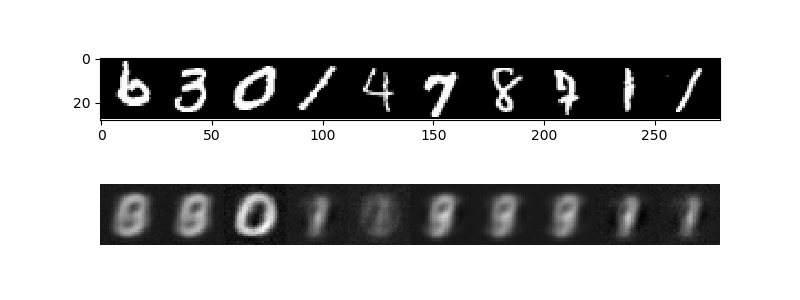

1: 0.676048755645752
2: 0.6642155647277832
3: 0.6529929637908936
4: 0.5969825983047485
5: 0.6195269227027893
6: 0.5870577096939087
7: 0.6141895651817322
8: 0.598222017288208


KeyboardInterrupt: 

In [263]:
bottleneck_size = 2

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.fc1a = nn.Linear(28**2, 100)
        self.fc1b = nn.Linear(100, bottleneck_size)
        self.fc2a = nn.Linear(bottleneck_size, 100)
        self.fc2b = nn.Linear(100, 28**2)

    def forward(self, x):
        x = x.view(-1, 28**2)
        x = F.relu(self.fc1a(x))
        x = F.relu(self.fc1b(x))
        x = F.relu(self.fc2a(x))
        return self.fc2b(x) # torch.sigmoid(self.fc2b(x)) # x = self.fc2b(x) 

    def encode(self, x):
        x = x.view(-1, 28**2)
        x = F.relu(self.fc1a(x))
        return self.fc1b(x)

    def decode(self, x):
        x = F.relu(self.fc2a(x))
        x = self.fc2b(x)
        return x

def draw(model):
    img = model(X_test).detach().numpy()
    img = img.reshape((-1, 28, 28)).transpose((1, 0, 2)).reshape(-1, 10*28)
    img = img * 0.3081 + 0.1307
    axs[1].imshow(img, cmap='gray')
    fig.canvas.draw()

def train(m, train_loader, optimizer, epoch, plot=None):
    m.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = m(data)
        if batch_idx % 100 == 0:
            draw(m)
        # MSE Loss!
        loss = F.mse_loss(output, data.view(-1, 28**2))
        loss.backward()
        optimizer.step()
    print(f"{epoch}: {loss}")

ae        = AutoEncoder()
optimizer = optim.SGD(ae.parameters(), lr=1e-2, momentum=0.9)
# optimizer = optim.Adam(ae.parameters(), lr=1e-2)

# Prepare some plotting
sample = next(iter(test_loader))
X_test = sample[0][:10].view(-1, 28, 28)
upper  = X_test.detach().numpy().transpose(1, 0, 2).reshape(-1, 10*28)

fig, axs = plt.subplots(2, 1, figsize=(8,3))
fig.show()
axs[0].imshow(upper, cmap='gray')

for epoch in range(1, 11):
    train(ae, train_loader, optimizer, epoch)


In [261]:
ae1 = ae

Now we can compress images into a two dimensional space, where we can actually plot their position against each other. Let's do that.

<IPython.core.display.Javascript object>


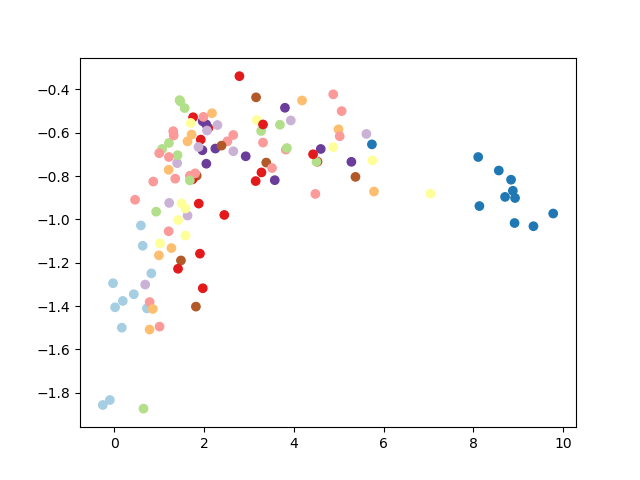

In [205]:
# This import registers the 3D projection, but is otherwise unused.
sample   = next(iter(train_loader))
X_train  = sample[0].view(-1, 28, 28)
embed    = ae.encode(X_train).detach().numpy()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(embed[:,0], embed[:,1], c=sample[1], cmap='Paired')

This is okay but there is no clear relation between the classes and the embeddings. Okay, there are some tendencies, but it is not easy to generate new data. We could try though. 

[ 3.85590534 -0.54984297]
[ 3.8665252  -0.56243682]
[ 4.05852637 -0.54166661]
[ 3.82424976 -0.5717055 ]
[ 3.97737944 -0.59924795]
[ 4.27706759 -0.53199056]
[ 4.2166737 -0.5567061]
[ 3.4710648  -0.59364629]
[ 4.15950526 -0.55300673]
[ 3.71416691 -0.56180579]


<IPython.core.display.Javascript object>


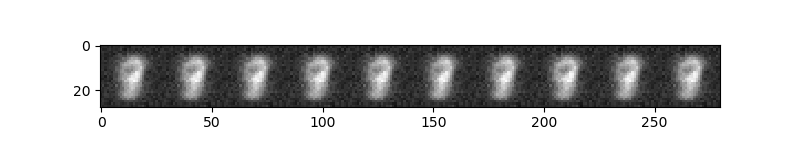

In [204]:
samples = np.zeros((10, 2))
for i in range(10):
    sel = sample[1] == i
    mu  = np.mean(embed[sel], axis=0)
    var = np.var(embed[sel], axis=0)
    samples[i] = np.random.multivariate_normal(mu, np.diag(var))

# samples = np.random.normal(mu, np.diag(std), (10, 3))
generated = ae.decode(torch.from_numpy(samples).float())

fig, ax = plt.subplots(figsize=(8,1.5))

img = generated.detach().numpy()
img = img.reshape((-1, 28, 28)).transpose((1, 0, 2)).reshape(-1, 10*28)
img = img * 0.3081 + 0.1307
ax.imshow(img, cmap='gray')


## Variational Auto-encoders


The motivation is now to find a way to make the embeddings more structured. Here, we refer to structure as a simple distribution, that can easily be sampled from. Let's formalize this a bit.

### The Theoretical Motivation

Up til now, we have considered auto-encoders consisting of two components.

1. An encoder $q(z | x)$, that approximates some unknown prior distribution p(z | X)
2. A decoder $p(X | z)$, that approximately decodes the latent variables into the space of $X$.

Ideally, we would like to be able to infer the distribution $


### Using Neural Networks


<IPython.core.display.Javascript object>


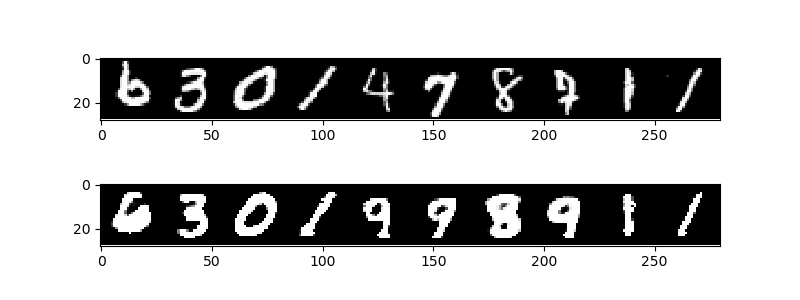

1: -11155.469234674072
2: -16349.074064583334
3: -17416.407145833335
4: -17975.604122916666
5: -18278.983620833333
6: -18473.6779125
7: -18625.743797916668
8: -18762.081195833332
9: -18868.445758333335
10: -18968.58914583333


In [264]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, bottleneck_size)
        self.fc22 = nn.Linear(400, bottleneck_size)
        self.fc3 = nn.Linear(bottleneck_size, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        x  = x.view(-1, 28**2)
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 28**2))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


vae = VAE()
optimizer = optim.Adam(vae.parameters(), lr=1e-3)


def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


def draw(model):
    img = model(X_test)[0].detach().numpy()
    img = img.reshape((-1, 28, 28)).transpose((1, 0, 2)).reshape(-1, 10*28)
    img = img * 0.3081 + 0.1307
    axs[1].imshow(img, cmap='gray')
    fig.canvas.draw()


def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(data)
        
        if batch_idx % 100 == 0:
            draw(vae)

        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f"{epoch}: {train_loss / len(train_loader.dataset)}")


fig, axs = plt.subplots(2, 1, figsize=(8,3))
fig.show()
axs[0].imshow(upper, cmap='gray')
    
for epoch in range(1, 11):
    train(epoch)


<IPython.core.display.Javascript object>


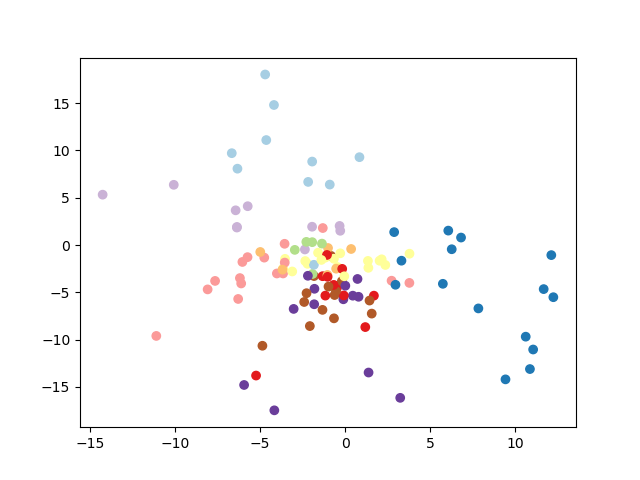

tensor([2, 5, 9, 8, 7, 4, 1, 0, 3, 6])


In [266]:
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

X_train  = sample[0].view(-1, 28, 28)
mu, logvar    = vae.encode(X_train)
mu = mu.detach().numpy()
# var = torch.exp(logvar)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(mu[:,0], mu[:,1], c=sample[1], cmap='Paired')
print(sample[1].unique())

[[ 0.  10. ]
 [ 0.   9.5]
 [ 0.   9. ]
 [ 0.   8.5]
 [ 0.   8. ]
 [ 0.   7.5]
 [ 0.   7. ]
 [ 0.   6.5]
 [ 0.   6. ]
 [ 0.   5.5]
 [ 0.   5. ]]


<IPython.core.display.Javascript object>


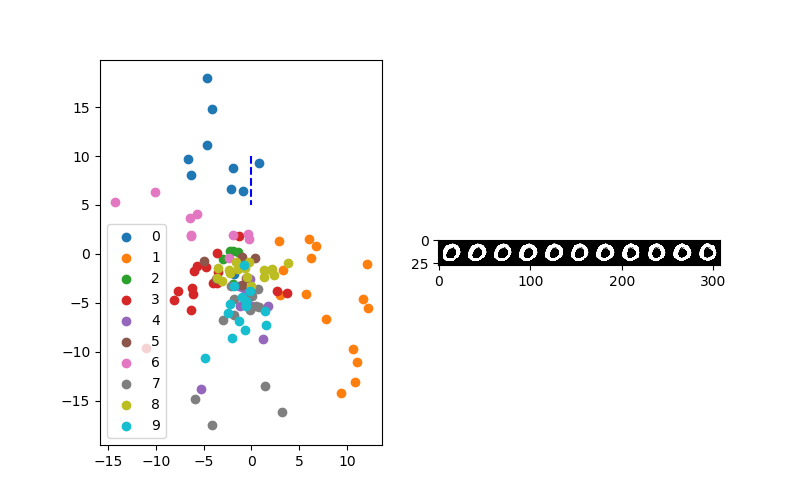

In [267]:
y = sample[1].numpy()
mean_0  = mu[y == 0]
mean_3  = mu[y == 3]
mean_0  = np.array([0, 5]) # mean_0.(axis=0)
mean_3  = np.array([0, 10]) # mean_0.mean(axis=0)

diff    = (mean_0 - mean_3) / 10
Zs      = np.zeros((11, 2))
Zs[0]   = mean_3
for i in range(1, 11):
    Zs[i] = Zs[i-1] + diff

print(Zs)

# samples = np.random.normal(mu, np.diag(std), (10, 3))
generated = vae.decode(torch.from_numpy(Zs).float())

fig, ax = plt.subplots(1, 2, figsize=(8,5))

for i in range(10):
    sel = y == i
    ax[0].scatter(mu[sel,0], mu[sel,1], label=f"{i}")
ax[0].legend()
ax[0].plot(Zs[:,0], Zs[:,1], 'b--', label="Dir. of variation")

img = generated.detach().numpy()
img = img.reshape((-1, 28, 28)).transpose((1, 0, 2)).reshape(-1, 11*28)
img = img * 0.3081 + 0.1307
ax[1].imshow(img, cmap='gray')

In [212]:
print(np.arange(11) / 10)


[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


### Disintangeling the latent variables

We might want to try to make the the dimensions of the latent space independent. That way, we would hope that different variables would encode different aspects of the numbers, e.g., one variable holding the number it self, another holding scale, a third variable holding rotation, etc. 

This was done by [3], where they introduce a $\beta$ term to the objective function:

$$

$$

In short, $\beta$ forces the optimization to focus more on letting the prior distribution $q(z|X)$ be simple and nicely behaving. An example is the following.

![Latent features](disentangeling.png)

# References
[[1]](https://arxiv.org/pdf/1312.6114.pdf) Kingma, D.P. and Welling, M., 2013. Auto-encoding variational bayes. arXiv preprint arXiv:1312.6114.  
[[2]](https://arxiv.org/pdf/1606.05908.pdf) Doersch, C., 2016. Tutorial on variational autoencoders. arXiv preprint arXiv:1606.05908.
[[3]](https://arxiv.org/pdf/1606.05579.pdf) Higgins, I., Matthey, L., Glorot, X., Pal, A., Uria, B., Blundell, C., Mohamed, S. and Lerchner, A., 2016. Early visual concept learning with unsupervised deep learning. arXiv preprint arXiv:1606.05579.